In [1]:
# 必要なモジュールのインポート
import numpy as np # 行列計算
import pandas as pd # データ分析用
from matplotlib import pyplot as plt, dates as mdates # グラフ描画
import datetime as dt# 日付
%pip install japanize-matplotlib # japanize_matplotlib をインストール
import japanize_matplotlib # matplotlibの日本語化（豆腐回避⦆

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.1 MB 6.1 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=ca3ea3a11a144113884494d8d6d4df510edcbc883e1c2a82e1a89a935ae4036d
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


# 日本のデータ

In [4]:
# 県名リスト
prefs = ['ALL', 'Hokkaido', 'Aomori', 'Iwate', 'Miyagi', 'Akita', 'Yamagata',
       'Fukushima', 'Ibaraki', 'Tochigi', 'Gunma', 'Saitama', 'Chiba', 'Tokyo',
       'Kanagawa', 'Niigata', 'Toyama', 'Ishikawa', 'Fukui', 'Yamanashi',
       'Nagano', 'Gifu', 'Shizuoka', 'Aichi', 'Mie', 'Shiga', 'Kyoto', 'Osaka',
       'Hyogo', 'Nara', 'Wakayama', 'Tottori', 'Shimane', 'Okayama',
       'Hiroshima', 'Yamaguchi', 'Tokushima', 'Kagawa', 'Ehime', 'Kochi',
       'Fukuoka', 'Saga', 'Nagasaki', 'Kumamoto', 'Oita', 'Miyazaki',
       'Kagoshima', 'Okinawa']
# 新規陽性者数を cases に取り込み，日付をインデックスにする
cases_url = "https://covid19.mhlw.go.jp/public/opendata/newly_confirmed_cases_daily.csv" # データの在処
cases = pd.read_csv(cases_url) # データフレームに取り込む
cases["Date"] = pd.to_datetime(cases["Date"]) # "Date"の列を文字列から日付オブジェクトに変換
cases = cases.set_index("Date") # "Date"列をインデックスに設定
# 累積死亡者数データを読込む
deaths_url = "https://covid19.mhlw.go.jp/public/opendata/deaths_cumulative_daily.csv" # データの在処
deaths = pd.read_csv(deaths_url) # データフレームに取り込む
deaths["Date"] = pd.to_datetime(deaths["Date"]) # "Date"の列を文字列から日付オブジェクトに変換
deaths = deaths.set_index("Date") # "Date"列をインデックスに設定
deaths = deaths.diff() # 差分を取って新規死亡者数に変換
# 重症者数
severe_url = "https://covid19.mhlw.go.jp/public/opendata/severe_cases_daily.csv" # データの在処
severe = pd.read_csv(severe_url) # データフレームに取り込む
severe["Date"] = pd.to_datetime(severe["Date"]) # "Date"の列を文字列から日付オブジェクトに変換
severe = severe.set_index("Date") # "Date"列をインデックスに設定
# read_csv を使って CSV 形式のデータを読込む
hospitalized = pd.read_csv('https://www.stopcovid19.jp/data/covid19japan_beds/all.csv')
# 更新日を日付データに置き換える
hospitalized["更新日"] = pd.to_datetime(hospitalized["更新日"])
# なぜか未来の日付のデータが混入しているので取除く
hospitalized = hospitalized[hospitalized["更新日"]<=dt.datetime.today()]
# fillna(0)でデータ欠損部分をゼロ埋めし，整数型に変換する
hospitalized["入院者数"] = hospitalized["入院者数"].fillna(0).astype(int)
# read_csv を使って CSV 形式のデータを読込む
hospitalized = pd.read_csv('https://www.stopcovid19.jp/data/covid19japan_beds/all.csv')
# 更新日を日付データに置き換える
hospitalized["更新日"] = pd.to_datetime(hospitalized["更新日"])
# なぜか未来の日付のデータが混入しているので取除く
hospitalized = hospitalized[hospitalized["更新日"]<=dt.datetime.today()]
# fillna(0)でデータ欠損部分をゼロ埋めし，整数型に変換する
hospitalized["入院者数"] = hospitalized["入院者数"].fillna(0).astype(int)
hospitalized = hospitalized.set_index(["都道府県番号","更新日"])["入院者数"].sort_index().unstack().T
hospitalized = pd.concat([hospitalized.sum(axis=1), hospitalized], axis=1)
hospitalized.columns=prefs
# マルチインデックスのデータフレームにまとめる
jp_df = pd.concat([cases.stack(), deaths.stack(), hospitalized.stack(), severe.stack()], axis=1).swaplevel(0,1).sort_index().loc[prefs]
jp_df.columns=["cases", "deaths", "hospitalized", "severe_cases"]

In [5]:
jp_df # 日本のデータフレームを表示

cases  deaths  hospitalized  severe_cases
ALL     2020-01-16      1     NaN           NaN           NaN
        2020-01-17      0     NaN           NaN           NaN
        2020-01-18      0     NaN           NaN           NaN
        2020-01-19      0     NaN           NaN           NaN
        2020-01-20      0     NaN           NaN           NaN
...                   ...     ...           ...           ...
Okinawa 2022-07-09   2518     0.0           NaN          13.0
        2022-07-10   2458     0.0           NaN          13.0
        2022-07-11    943     0.0           NaN          13.0
        2022-07-12   3436     4.0           NaN          14.0
        2022-07-13   3518     0.0           NaN          19.0

[43680 rows x 4 columns]

Text(2022-02-05 00:00:00, 88133.71428571429, '第6波\nピーク')

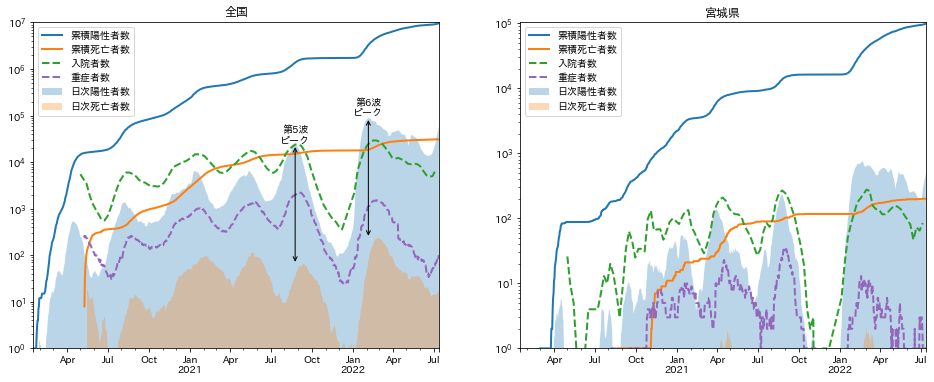

In [6]:
# 県別のデータをグラフ描画する関数
def plot_pref(pref, title, ax, tw=7):
    pref_df = jp_df.loc[pref]
    nc, nd, hs, sc = pref_df["cases"], pref_df["deaths"], pref_df["hospitalized"], pref_df["severe_cases"]
    nc.cumsum().plot(ax=ax, lw=2, label="累積陽性者数")
    nd.cumsum().plot(ax=ax, lw=2, label="累積死亡者数")
    hs.dropna().plot(ax=ax, lw=2, ls='--', color="tab:green", label="入院者数")
    sc.plot(ax=ax, lw=2, ls='--', color="tab:purple", label="重症者数")
    ax.fill_between(nc.index, nc.rolling(tw).mean(), alpha=0.3, label="日次陽性者数")
    ax.fill_between(nd.index, nd.rolling(tw).mean(), alpha=0.3, label="日次死亡者数")
    ax.set_ylim([1, ax.get_ylim()[1]])
    ax.set_yscale('log')
    ax.set_title(title)
    ax.legend()
# wvで与えられた期間から新規陽性者と新規死亡者の7日間移動平均のピークを求める関数
def wave_peak(pref, wv, rw=7):
    pref_df = jp_df.loc[pref]
    wv_df = pref_df.loc[wv]
    wv_cases = wv_df.cases.rolling(rw).mean()
    wv_deaths = wv_df.deaths.rolling(rw).mean()
    pk = wv_cases.idxmax()
    pk_cases = wv_cases.max()
    pk_deaths = wv_deaths.max()
    return pk, pk_cases, pk_deaths

# 全国と宮城県について，感染状況をプロット
fig, [ax0, ax1] = plt.subplots(1,2,figsize=(8*2,6))
plot_pref("ALL", "全国", ax0)
plot_pref("Miyagi", "宮城県", ax1)

# 第五波と第六波のピーク時の陽性者数と死亡者数を求め，その差を矢印で表示
wv5 = pd.date_range('2021-07-01','2021-10-1') # 第五波の期間
pk5, pk5_cases, pk5_deaths = wave_peak("ALL", wv5) # 第五波のピーク
ax0.annotate("", xytext=(pk5, pk5_cases), xy=(pk5, pk5_deaths), arrowprops=dict(arrowstyle="<->")) # 全国のグラフに矢印を追記
ax0.annotate("第5波\nピーク", xy=(pk5,pk5_cases), ha="center", va="bottom") # 「第五波ピーク」という文字を追記
wv6 = pd.date_range('2022-01-01','2022-06-20') # 第六波の期間
pk6, pk6_cases, pk6_deaths = wave_peak("ALL", wv6) # 第六波のピーク
ax0.annotate("", xytext=(pk6, pk6_cases), xy=(pk6, pk6_deaths), arrowprops=dict(arrowstyle="<->")) # 全国のグラフに矢印を追記
ax0.annotate("第6波\nピーク", xy=(pk6,pk6_cases), ha="center", va="bottom") # 「第六波ピーク」という文字を追記

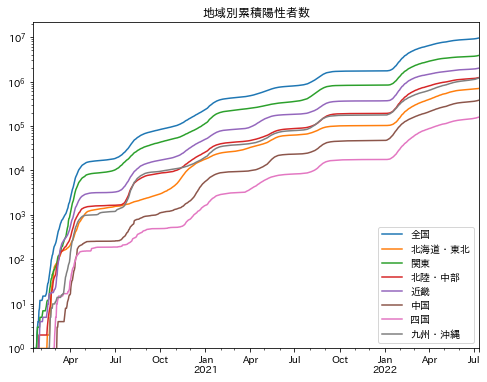

In [7]:
# 地域別の累積陽性者数をプロット
regions = {
    '全国': ['ALL'],
    '北海道・東北':['Hokkaido', 'Aomori', 'Akita', 'Iwate', 'Miyagi', 'Yamagata', 'Fukushima'],
    '関東':['Tokyo', 'Ibaraki', 'Tochigi', 'Gunma', 'Saitama', 'Chiba', 'Kanagawa'],
    '北陸・中部':['Niigata', 'Toyama', 'Ishikawa', 'Fukui','Yamanashi', 'Nagano', 'Gifu', 'Shizuoka', 'Aichi'],
    '近畿':['Kyoto', 'Osaka', 'Mie', 'Shiga', 'Hyogo', 'Nara', 'Wakayama'],
    '中国':['Tottori', 'Shimane', 'Okayama', 'Hiroshima', 'Yamaguchi'],
    '四国':['Tokushima', 'Kagawa', 'Ehime', 'Kochi'],
    '九州・沖縄':['Fukuoka', 'Saga', 'Nagasaki', 'Oita', 'Kumamoto', 'Miyazaki', 'Kagoshima', 'Okinawa']}
fig, ax = plt.subplots(1,1,figsize=(8,6))
rw = 14
for r in regions:
    region_df = jp_df.loc[regions[r]].groupby(level=1).sum() # 当該地域に含まれる県のデータをインデックスレベル1(日付)で集計したものを region_df とする
    nc, nd, hs, sc = region_df.cases, region_df.deaths, region_df.hospitalized, region_df.severe_cases
    nc.cumsum().plot(ax=ax, label=r)
ax.set_title("地域別累積陽性者数")
ax.set_yscale('log')
ax.set_ylim([1, ax.get_ylim()[1]])
ax.legend()
plt.show()

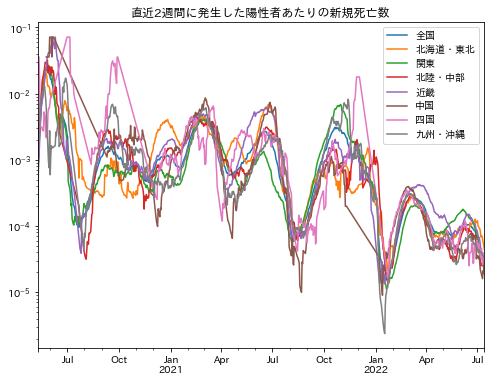

In [8]:
# 直近2週間に発生した陽性者あたりの新規死亡数をプロット(レポートのサンプルでは未使用)
fig, ax = plt.subplots(1,1,figsize=(8,6))
rw = 14
lag = 14
for r in regions:
    region_df = jp_df.loc[regions[r]].groupby(level=1).sum() # 当該地域に含まれる県のデータをインデックスレベル1(日付)で集計したものを region_df とする
    nc, nd, hs, sc = region_df.cases, region_df.deaths, region_df.hospitalized, region_df.severe_cases
    cfr = nd.rolling(rw).mean()/nc.cumsum().diff(lag)
#    cfr = nd[::-1].cumsum()/nc[::-1].cumsum()
    cfr = cfr[cfr>1e-6]
    cfr.plot(ax=ax, label=r)
ax.set_title("直近2週間に発生した陽性者あたりの新規死亡数")
ax.set_yscale('log')
#ax.set_ylim([1, ax.get_ylim()[1]])
ax.legend()
plt.show()

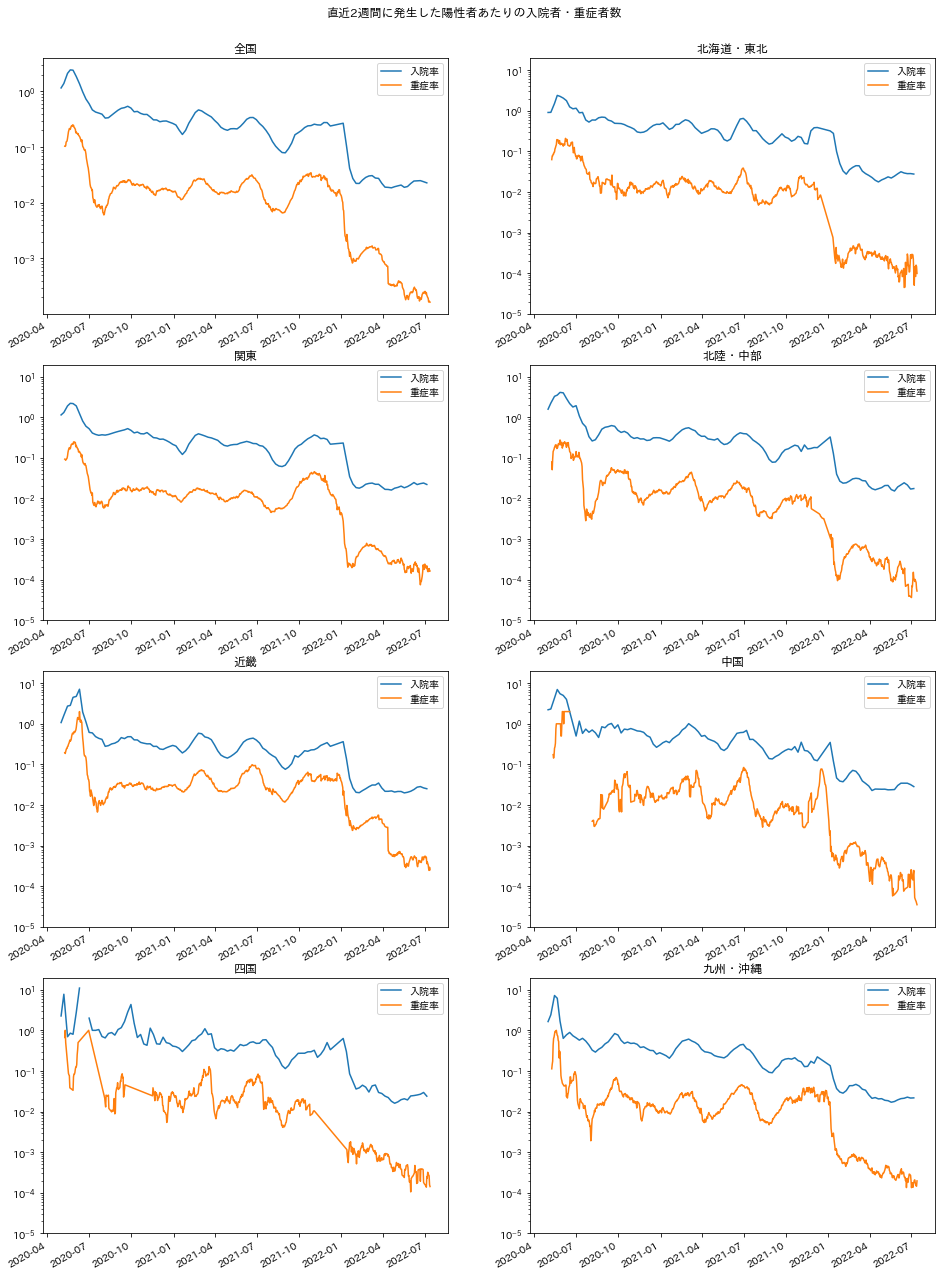

In [9]:
# 直近2週間に発生した陽性者あたりの入院者・重症者数（レポートのサンプルでは未使用)
rows = 4
cols = 2
fig, ax_tab = plt.subplots(rows, cols, figsize=(8*cols, 6*rows))
fig.suptitle("直近2週間に発生した陽性者あたりの入院者・重症者数", y=0.91)
axs = ax_tab.flatten()
lag = 14
for rid, r in enumerate(regions):
    #print(r, regions[r])
    ax = axs[rid]
    region_df = jp_df.loc[regions[r]].groupby(level=1).sum() # 当該地域に含まれる県のデータをインデックスレベル1(日付)で集計したものを region_df とする
    nc, nd, hs, sc = region_df.cases, region_df.deaths, region_df.hospitalized, region_df.severe_cases
    (hs/nc.cumsum().diff(lag))[hs>0].plot(ax = ax, label="入院率")
    (sc/nc.cumsum().diff(lag))[sc>0].plot(ax = ax, label="重症率")
    ax.set_title(r)
    ax.set_yscale('log')
    ax.legend()
ymax = max([ax.get_ylim()[1] for ax in axs[1:]])
for ax in axs[1:]:
    ax.set_ylim([1e-5,ymax])

# 海外のデータ

In [11]:
# CSVをデータフレームに読み込む（ちょっと重い）
global_df = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
# 年-月-日の文字列で記載されている年月日を datetime 型に変更
global_df["date"]=pd.to_datetime(global_df["date"], format="%Y-%m-%d")
# 県別でも扱ったマルチインデックスとして整形
global_df = global_df.set_index(["location", "date"])
global_df # global_df の概観を表示

iso_code continent  total_cases  new_cases  \
location    date                                                    
Afghanistan 2020-02-24      AFG      Asia          5.0        5.0   
            2020-02-25      AFG      Asia          5.0        0.0   
            2020-02-26      AFG      Asia          5.0        0.0   
            2020-02-27      AFG      Asia          5.0        0.0   
            2020-02-28      AFG      Asia          5.0        0.0   
...                         ...       ...          ...        ...   
Zimbabwe    2022-07-09      ZWE    Africa     255924.0       33.0   
            2022-07-10      ZWE    Africa     255939.0       15.0   
            2022-07-11      ZWE    Africa     255953.0       14.0   
            2022-07-12      ZWE    Africa     255981.0       28.0   
            2022-07-13      ZWE    Africa     255981.0        0.0   

                        new_cases_smoothed  total_deaths  new_deaths  \
location    date                                                       
Afghanistan 2020-02-24                 NaN           NaN         NaN   
            2020-02-25                 NaN           NaN         NaN   
            2020-02-26                 NaN           NaN         NaN   
            2020-02-27                 NaN           NaN         NaN   
            2020-02-28                 NaN           NaN         NaN   
...                                    ...           ...         ...   
Zimbabwe    2022-07-09              48.286        5563.0         1.0   
            2022-07-10              50.429        5564.0         1.0   
            2022-07-11              32.429        5565.0         1.0   
            2022-07-12              32.286        5565.0         0.0   
            2022-07-13              25.143        5565.0         0.0   

                        new_deaths_smoothed  total_cases_per_million  \
location    date                                                       
Afghanistan 2020-02-24                  NaN                    0.125   
            2020-02-25                  NaN                    0.125   
            2020-02-26                  NaN                    0.125   
            2020-02-27                  NaN                    0.125   
            2020-02-28                  NaN                    0.125   
...                                     ...                      ...   
Zimbabwe    2022-07-09                1.143                16001.727   
            2022-07-10                1.286                16002.665   
            2022-07-11                1.000                16003.540   
            2022-07-12                1.000                16005.291   
            2022-07-13                0.714                16005.291   

                        new_cases_per_million  ...  female_smokers  \
location    date                               ...                   
Afghanistan 2020-02-24                  0.125  ...             NaN   
            2020-02-25                  0.000  ...             NaN   
            2020-02-26                  0.000  ...             NaN   
            2020-02-27                  0.000  ...             NaN   
            2020-02-28                  0.000  ...             NaN   
...                                       ...  ...             ...   
Zimbabwe    2022-07-09                  2.063  ...             1.6   
            2022-07-10                  0.938  ...             1.6   
            2022-07-11                  0.875  ...             1.6   
            2022-07-12                  1.751  ...             1.6   
            2022-07-13                  0.000  ...             1.6   

                        male_smokers  handwashing_facilities  \
location    date                                               
Afghanistan 2020-02-24           NaN                  37.746   
            2020-02-25           NaN                  37.746   
            2020-02-26           NaN                  37.746   
            2020-02-

In [12]:
# 人口100万人あたり死亡者数が多い国を求める
rank = 30
top_TDPM= global_df[~global_df['iso_code'].str.contains("OWID")].groupby("location").last().sort_values("total_deaths_per_million", ascending=False).head(rank).index.values.tolist() 
top_TDPM += ['Japan', 'World']
top_TDPM = global_df.loc[top_TDPM].groupby("location").last().sort_values("total_deaths_per_million", ascending=False).index.values.tolist()
top_TDPM

['Peru',
 'Bulgaria',
 'Bosnia and Herzegovina',
 'Hungary',
 'Georgia',
 'North Macedonia',
 'Montenegro',
 'Croatia',
 'Czechia',
 'Moldova',
 'Slovakia',
 'San Marino',
 'Romania',
 'Lithuania',
 'Gibraltar',
 'Brazil',
 'Slovenia',
 'Latvia',
 'Armenia',
 'Poland',
 'United States',
 'Chile',
 'Greece',
 'Italy',
 'Argentina',
 'Paraguay',
 'Belgium',
 'Colombia',
 'United Kingdom',
 'Ukraine',
 'World',
 'Japan']

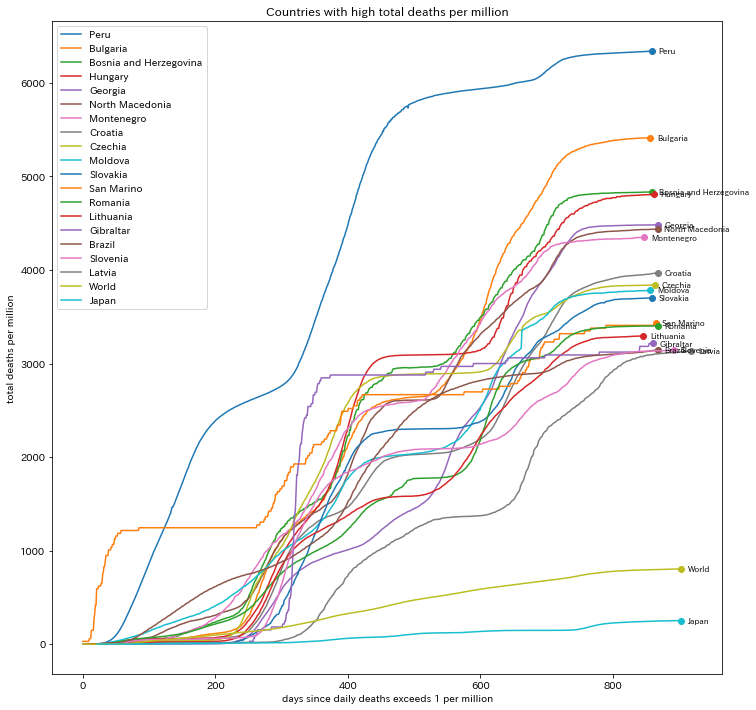

In [14]:
# 人口あたり死亡数の多い国+日本+世界について，人口100万人あたりの死亡者数の推移をプロット
rank = 18
top_TDPM= global_df[~global_df['iso_code'].str.contains("OWID")].groupby("location").last().sort_values("total_deaths_per_million", ascending=False).head(rank).index.values.tolist() 
top_TDPM += ['Japan', 'World']
top_TDPM = global_df.loc[top_TDPM].groupby("location").last().sort_values("total_deaths_per_million", ascending=False).index.values.tolist()

fig, ax = plt.subplots(1, 1, figsize=(12,12))
for c in top_TDPM:
    c_df = global_df.loc[c]
    c_df[c_df.new_deaths_per_million > 1] # 人口100万人あたりの新規死亡数が1を超えてからのデータに限定
    x = (c_df.index-c_df.index[0]).days # 横軸を人口100万人あたりの新規死亡数が1を超えてからの日数に
    y = c_df.total_deaths_per_million # 縦軸は人口100万人あたりの新規死亡数に
    ax.plot( x, y, label=c) # プロット
    ax.scatter(x[-1], y[-1]) # 線の末端に◯を表示
    ax.annotate(c, xy=(x[-1]+10, y[-1]), size=8, ha='left', va='center') # ◯の右側に国名を表示
# グラフの見栄えを修正
ax.set_title("Countries with high total deaths per million")
ax.set_ylabel("total deaths per million")
ax.set_xlabel("days since daily deaths exceeds 1 per million")
ax.legend()
plt.show()

In [15]:
# 上位の国の100人あたり死亡者数を確認
global_df.loc[["Peru", "Bulgaria", "Hungary", "World"]].groupby("location").last().total_deaths_per_million

location
Bulgaria    5414.132
Hungary     4809.169
Peru        6339.256
World        804.434
Name: total_deaths_per_million, dtype: float64

In [26]:
# ワクチン接種率だけが問題かどうかを確認
global_df.loc[["Peru", "Ecuador", "Bulgaria", "Hungary", "World", "Japan", "Portugal"]].groupby("location").last().loc[:,["total_deaths_per_million", "people_fully_vaccinated_per_hundred"]]

,total_deaths_per_million,people_fully_vaccinated_per_hundred
location,,
Bulgaria,5414.132,30.15
Ecuador,2009.750,78.75
Hungary,4809.169,63.85
Japan,252.759,82.20
Peru,6339.256,82.25
Portugal,2368.198,86.34
World,804.434,61.23


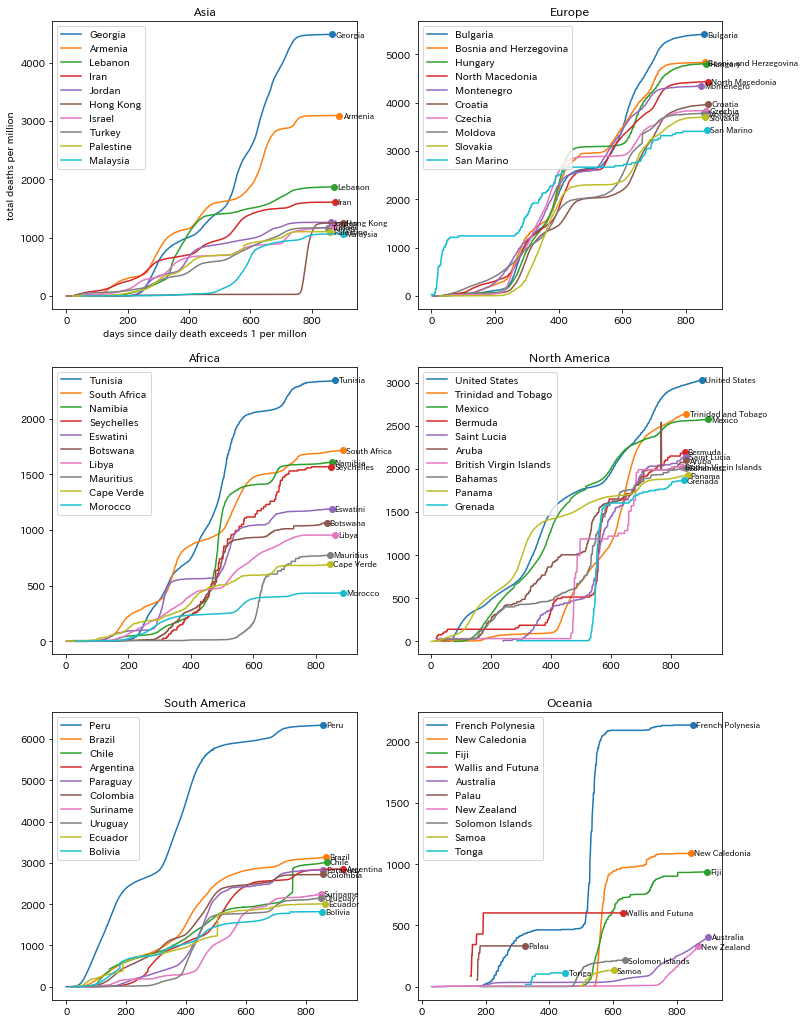

In [27]:
# 大陸・圏域ごとに人口あたり死亡者数の多い国をプロット
rows, cols = 3, 2
fig, ax_tab = plt.subplots(rows, cols, figsize=(6*cols, 6*rows))
axs = ax_tab.flatten()
regions = ['Asia', 'Europe', 'Africa', 'North America',  'South America', 'Oceania']
for rid, r in enumerate(regions):
    if r == 'World':
        gdf = global_df[~global_df.iso_code.str.contains("OWID")]
    else:
        gdf = global_df[global_df.continent == r]
    top_TDPM = gdf.groupby("location").last().total_deaths_per_million.sort_values(ascending=False).head(10).index.tolist()
    ax = axs[rid]
    for c in top_TDPM:
        c_df = global_df.loc[c]
        c_df[c_df.new_deaths_per_million > 1] # 
        x = (c_df.index-c_df.index[0]).days
        y = c_df.total_deaths_per_million
        ax.plot( x, y, label=c)
        ax.scatter(x[-1], y[-1])
        ax.annotate(c, xy=(x[-1]+10, y[-1]), size=8, ha='left', va='center')
    ax.set_title(r)
    if rid == 0:
        ax.set_ylabel("total deaths per million")
        ax.set_xlabel("days since daily death exceeds 1 per millon")
    ax.legend()
ymax = max([ax.get_ylim()[1] for ax in axs])
#for ax in axs:
#    ax.set_ylim([0, ymax])
#axs[-1].axis('off')
plt.show()